Epoch   500 | loss 1.954e+07 (int 6.6e-01, bnd 2.0e+07) | lr 9.05e-06
Epoch  1000 | loss 1.954e+07 (int 6.4e-01, bnd 2.0e+07) | lr 6.58e-06
Epoch  1500 | loss 1.954e+07 (int 6.3e-01, bnd 2.0e+07) | lr 3.52e-06
Epoch  2000 | loss 1.954e+07 (int 6.2e-01, bnd 2.0e+07) | lr 1.05e-06
Epoch  2500 | loss 1.954e+07 (int 6.1e-01, bnd 2.0e+07) | lr 8.02e-06
Epoch  3000 | loss 1.954e+07 (int 5.7e-01, bnd 2.0e+07) | lr 7.68e-06
Epoch  3500 | loss 1.954e+07 (int 5.2e-01, bnd 2.0e+07) | lr 6.71e-06
Epoch  4000 | loss 1.954e+07 (int 4.7e-01, bnd 2.0e+07) | lr 5.28e-06
Epoch  4500 | loss 1.954e+07 (int 4.3e-01, bnd 2.0e+07) | lr 3.65e-06
Epoch  5000 | loss 1.954e+07 (int 4.0e-01, bnd 2.0e+07) | lr 2.08e-06
Epoch  5500 | loss 1.954e+07 (int 3.9e-01, bnd 2.0e+07) | lr 8.56e-07
Epoch  6000 | loss 1.954e+07 (int 3.8e-01, bnd 2.0e+07) | lr 1.87e-07
Epoch  6500 | loss 1.954e+07 (int 3.5e-01, bnd 2.0e+07) | lr 6.41e-06
Epoch  7000 | loss 1.954e+07 (int 2.8e-01, bnd 2.0e+07) | lr 6.16e-06
Epoch  7500 | loss 1

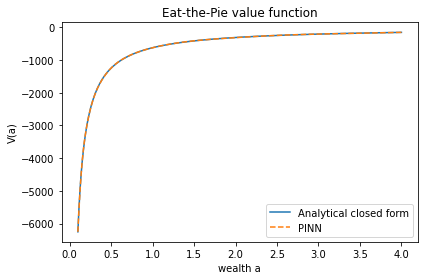

In [26]:
"""
Eat-the-Pie HJB  ·  Physics-Informed Neural Net  ·  TensorFlow 2 + TF-Prob
================================================================================
CRRA agent with no income risk:

    • Wealth   : da = ( r·a – c ) dt
    • Utility  : u(c) = c^(1-γ)/(1-γ) , γ ≠ 1
    • HJB      : ρV = max_c { u(c) + V_a ( r a – c ) }

FOC  →  c(a) = V_a(a)^(-1/γ)
Closed form (slides, “Eat-the-Pie: no risk, no income”):

        κ = (ρ – (1-γ) r) / γ     (κ>0)
        V*(a) = (1/(1-γ)) κ^(-γ) a^(1-γ)
        c*(a) = κ·a

This script trains a PINN to recover V*(a).  
Toggle `USE_COSINE_SCHED` to switch between a fixed LR Adam and the
Cosine-Decay-Restarts scheduler given in your pseudo-code.  
The code keeps the learning schedule, optimiser settings, and two-phase
Adam → L-BFGS structure of your template, but the PDE, domain and
analytical solution are now those of the one-dimensional pie-eating
problem.  A global seed makes the run fully reproducible.
"""

# ── user switches ───────────────────────────────────────────────────────────
USE_COSINE_SCHED = True   # True = CosineDecayRestarts, False = fixed-LR Adam
SEED              = 666   # reproducibility

# ── 0. imports, dtype, seed ─────────────────────────────────────────────────
import os, random, numpy as np
# os.environ["CUDA_VISIBLE_DEVICES"] = ""         # ← uncomment to force CPU

import tensorflow as tf, tensorflow_probability as tfp, matplotlib.pyplot as plt
np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)

DTYPE = tf.float64
tf.keras.backend.set_floatx('float64')

# ── 1. model parameters & helpers ───────────────────────────────────────────
# HJB parameters (choose γ>1 and ρ>(1-γ)r so κ>0)
gamma = 2.0
rho   = 0.05
r     = 0.03
kappa = (rho - (1-gamma)*r) / gamma      # 0.04 with the numbers above

# wealth domain
a_min, a_max = 0.1, 4.0

def scale_a(a):   return (a - a_min) / (a_max - a_min)
def unscale_a(u): return a_min + u * (a_max - a_min)

# analytical solution
def V_star_np(a): return (1/(1-gamma)) * (kappa**(-gamma)) * a**(1-gamma)
def V_star_tf(a): return (1/(1-gamma)) * (kappa**(-gamma)) * a**(1-gamma)

# analytically optimal consumption
def c_star_np(a): return kappa * a

# ── 2. PINN architecture ────────────────────────────────────────────────────
class PINN(tf.keras.Model):
    def __init__(self, layers=(128,64,32)):
        super().__init__()
        self.hidden = [tf.keras.layers.Dense(n, 'gelu',
                           kernel_initializer='glorot_uniform',
                           dtype=DTYPE) for n in layers]
        self.out = tf.keras.layers.Dense(1, dtype=DTYPE)
    def call(self, x):                      # x has shape (batch,1)
        z = x
        for lyr in self.hidden:
            z = lyr(z)
        return self.out(z)

net = PINN()

# ── 3. HJB residual (1-D) ───────────────────────────────────────────────────
@tf.function
def hjb_residual(a_scaled):
    a = unscale_a(a_scaled)                # back to original units

    with tf.GradientTape() as tape:
        tape.watch(a_scaled)
        V = net(a_scaled)                  # (N,1)
    V_a_scaled = tape.gradient(V, a_scaled)   # dV/du   (u = scaled a)
    V_a = V_a_scaled / (a_max - a_min)        # chain rule dV/da

    eps = tf.constant(1e-8, DTYPE)
    safe_Va = tf.nn.softplus(V_a) + eps      # ensure positivity
    c = safe_Va ** (-1.0 / gamma)            # FOC
    u = c ** (1-gamma) / (1-gamma)           # utility term

    residual = rho * V - (u + V_a * (r * a - c))
    return residual

# ── 4. samplers ─────────────────────────────────────────────────────────────
def sample_interior(N):
    u = np.random.rand(N,1)                # uniform in [0,1]
    return tf.convert_to_tensor(u, DTYPE)

def sample_boundary(N):
    # two endpoints
    low  = np.zeros((N//2,1))
    high = np.ones((N - N//2,1))
    u = np.vstack([low, high])
    return tf.convert_to_tensor(u, DTYPE)

# ── 5. loss & optimiser ------------------------------------------------------
w_int, w_bnd = 10.0, 1.0

if USE_COSINE_SCHED:
    lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate = 1e-5,
        first_decay_steps     = 2500,
        t_mul = 1.5, m_mul = 0.8, alpha = 0.01)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = lr_sched,
        amsgrad       = True,
        clipvalue     = 1.0)
else:
    optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def loss_parts(int_pts, bnd_pts):
    L_int = tf.reduce_mean(tf.square(hjb_residual(int_pts)))

    a_b = unscale_a(bnd_pts)
    V_b_true = V_star_tf(a_b)
    L_bnd = tf.reduce_mean(tf.square(net(bnd_pts) - V_b_true))

    return w_int*L_int + w_bnd*L_bnd, L_int, L_bnd

@tf.function
def adam_step(int_pts, bnd_pts):
    with tf.GradientTape() as tape:
        L, Li, Lb = loss_parts(int_pts, bnd_pts)
    grads = tape.gradient(L, net.trainable_variables)
    optimizer.apply_gradients(zip(grads, net.trainable_variables))
    return L, Li, Lb

# ── 6. Phase 1 : Adam SGD ----------------------------------------------------
EPOCHS, N_int, N_bnd = 8000, 512, 64
for ep in range(1, EPOCHS+1):
    L, Li, Lb = adam_step(sample_interior(N_int), sample_boundary(N_bnd))
    if ep % 500 == 0:
        if isinstance(optimizer.learning_rate,
                      tf.keras.optimizers.schedules.LearningRateSchedule):
            lr_now = optimizer.learning_rate(optimizer.iterations).numpy()
        else:
            lr_now = optimizer.learning_rate.numpy()
        print(f"Epoch {ep:5d} | loss {L.numpy():.3e} "
              f"(int {Li.numpy():.1e}, bnd {Lb.numpy():.1e}) | lr {lr_now:.2e}")

# ── 7. Phase 2 : L-BFGS fine-tune -------------------------------------------
def pack(ts):  return tf.concat([tf.reshape(t,[-1]) for t in ts],0)
def unpack(vec, templ):
    i = 0
    for v in templ:
        n = np.prod(v.shape)
        v.assign(tf.reshape(vec[i:i+n], v.shape))
        i += n

X_int_L, X_bnd_L = sample_interior(4096), sample_boundary(256)
def val_and_grad(theta):
    unpack(theta, net.trainable_variables)
    with tf.GradientTape() as tape:
        loss, _, _ = loss_parts(X_int_L, X_bnd_L)
    grad = pack(tape.gradient(loss, net.trainable_variables))
    return loss, grad

print("\nStarting L-BFGS …")
theta0 = pack(net.trainable_variables)
res = tfp.optimizer.lbfgs_minimize(
        val_and_grad, initial_position=theta0,
        max_iterations=400, tolerance=1e-9)
unpack(res.position, net.trainable_variables)
print("L-BFGS iterations:", res.num_iterations.numpy())

# ── 8. Diagnostics -----------------------------------------------------------
a_test = np.linspace(a_min, a_max, 300)[:,None]
u_test = scale_a(a_test)
V_pred = net(tf.convert_to_tensor(u_test, DTYPE)).numpy().ravel()
V_true = V_star_np(a_test.ravel())

mse = np.mean((V_pred - V_true)**2)
print(f"\nMSE over test grid : {mse:.3e}")

plt.figure(figsize=(6,4))
plt.plot(a_test, V_true, label='Analytical closed form')
plt.plot(a_test, V_pred, '--', label='PINN')
plt.xlabel('wealth a'); plt.ylabel('V(a)')
plt.title('Eat-the-Pie value function')
plt.legend(); plt.tight_layout(); plt.show()
